# Home App 
## Part IV- Predict the price of home using desired variables

The data for this project comes from Kaggle  [House Sales in King County, USA](https://www.kaggle.com/architdxb/king-countyusa/data). The list of variables is shown below.

The variables:

* **id** : house identification number
* **date** : date house was sold
* **price** : target variable for prediction
* **bedrooms** : number of bedrooms in the home
* **bathrooms** : number of bathrooms in the home
* **sqft_living** : square footage of the home
* **sqft_lot** : square footage of the lot
* **floors** : total floors in the home
* **waterfront** : 1 for home with a waterfront view, 0 otherwise
* **view** : has been viewed or not
* **condition** : How good the condition is overall
* **grade** : overall grade given to the housing unit, based on king county grading system
* **sqft_above** : square footage of home apart from basement
* **sqft_basement** : square footage of the basement
* **yr_built** : year the home was built
* **yr_renovated** : year the home was renovated
* **zipcode** : zip code of the home
* **lat** : latitude coordinate of the home
* **long** : longitude coordinate of the home
* **sqft_living15** : living room area in 2015
* **sqft_lot15** : lot area in 2015

For this part of the project, we will use the processed data from part III to create our ML model. 

For part IV of the project, we will: 

1. Read the processed data from Part III. 
2. Split the data into training/validation/test sets.  
3. Train a model with the supervised ML method with lowest mean square error. 
4. Perform parameter tuning to acquire a model with better performance. 

### I. Load and Merge Data

In [1]:
# load necessary packages 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import glob
import itertools
import seaborn as sns
from scipy import stats
from time import time

# pretty display for notebooks
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

from IPython.display import display # Allows the use of display() for DataFrames

# hide warnings
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)

data_path = "C:/Users/Yiruru/Documents/launchCode/data/processed_data.csv"
df= pd.read_csv(data_path)
# Load and merge the housing data
try:
    df = pd.read_csv(data_path)
    print("Main dataset has {} samples with {} features each.".format(*df.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Main dataset has 21969 samples with 8 features each.


### Train/Test data Split

Majority of the features have too many missing values, so we will only consider features with less than 10% of missing values. 

In [2]:
new_data = df
new_data.head(2)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,zipcode,year,price
0,7129300520,3,1.00,1180,5650,98178,1955,221900.0
1,6414100192,3,2.25,2570,7242,98125,1991,538000.0


In [3]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'year', 'zipcode']
price_raw = new_data['price']
features_raw = new_data.drop('price', axis = 1)
features_raw[numerical] = scaler.fit_transform(new_data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))
features = pd.get_dummies(features_raw)
price = new_data['price']

,id,bedrooms,bathrooms,sqft_living,sqft_lot,zipcode,year
0,7129300520,0.090909,0.125,0.06717,0.003108,0.893939,0.478261


In [4]:
# Train and Test 
X = new_data.ix[:, :-1]
Y = new_data.ix[:, -1]

# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(x_train.shape[0]))
print("Validation set has {} samples.".format(x_val.shape[0]))
print("Testing set has {} samples.".format(x_test.shape[0]))

# confirm % of test set
print("Testing set is {}%.".format(round(1.*x_test.shape[0]/features.shape[0]*100, 2)))

Training set has 15378 samples.
Validation set has 3296 samples.
Testing set has 3295 samples.
Testing set is 15.0%.


In [5]:
# Get data characteristics on the training set
n_train = round(len(x_train), 0)
n_val = round(len(x_val), 0)
n_test = round(len(x_test),1)

y_train_mean = y_train.mean()
y_val_mean = y_val.mean()
y_test_mean = y_test.mean()

basic_df = pd.DataFrame([['{:.0f}'.format(n_train), '{:.0f}'.format(n_val), '{:.0f}'.format(n_test)], 
                         ['{:.4f}'.format(y_train_mean), '{:.4f}'.format(y_val_mean), '{:.4f}'.format(y_test_mean)]], 
                        index=['Sample Size', 'log error'], 
                        columns=['Training Set', 'validation Set', 'Test Set'])
print('Table 3: Characteristics of Training, Validation, and Test Set')
basic_df

Table 3: Characteristics of Training, Validation, and Test Set


,Training Set,validation Set,Test Set
Sample Size,15378,3296,3295
log error,540842.6695,529067.9600,534933.2155


### Modeling 

In [6]:
import xgboost

from sklearn import cross_validation
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

#create classifiers
xgbrg= XGBRegressor(objective="reg:linear", random_state=100) 
gbrg = GradientBoostingRegressor(random_state=100) 
rfrg = RandomForestRegressor(random_state=100) 
dtrg = DecisionTreeRegressor(random_state=100) 
abrg = AdaBoostRegressor(random_state=100) 
brg = BaggingRegressor(random_state=100)

# train classifiers
xgbrg.fit(x_train, y_train, eval_metric = 'rmse', verbose = False, eval_set = [(x_test, y_test)])
gbrg.fit(x_train, y_train)
rfrg.fit(x_train, y_train)
dtrg.fit(x_train, y_train)
abrg.fit(x_train, y_train)
brg.fit(x_train, y_train)

# obtain predictions
xgbpreds = xgbrg.predict(x_val)
gbpreds = gbrg.predict(x_val)
rfpreds = rfrg.predict(x_val)
dtpreds = dtrg.predict(x_val)
abpreds = abrg.predict(x_val)
bpreds = brg.predict(x_val)

print('\nXGB Mean Square error ', mean_squared_error(y_val,xgbpreds))
print('GradientBoosting Mean Square error" ', mean_squared_error(y_val,gbpreds))
print('RandomForest Mean Square error" ', mean_squared_error(y_val,rfpreds))
print('DecisionTree Mean Square error" ', mean_squared_error(y_val,dtpreds))
print('AdaBoost Mean Square error" ', mean_squared_error(y_val,abpreds))
print('Bagging Mean Square error" ', mean_squared_error(y_val,bpreds))


XGB Mean Square error  34438488683.429756
GradientBoosting Mean Square error"  34430681312.74244
RandomForest Mean Square error"  31821144159.05133
DecisionTree Mean Square error"  51008838755.838135
AdaBoost Mean Square error"  72296524448.7404
Bagging Mean Square error"  32954825236.770092


We can see that gradient boosting performs the best, but we will actually choose XGB model for its known superiority in terms of training speed. We will now perform model tuning on XGB model. 

In [7]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import cohen_kappa_score, make_scorer, precision_score, recall_score
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

scoring_function = make_scorer(mean_squared_error, greater_is_better=False)
target = 'price'
predictors = new_data.columns[1:-1]

In [8]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval= True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['price'],eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
     
    #Print model report:
    print("\nModel Report")
    print("Mean Square error : %.4g" % metrics.mean_squared_error(dtrain['price'].values, dtrain_predictions))
    print("r2 Score : %.4g" % metrics.r2_score(dtrain['price'].values, dtrain_predictions))
    return dtrain_predictions

In [9]:
#combine x_train and y_train for model tuning 
df_train = pd.concat([x_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

# get a benchmark performance with our initial values
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=100)

m1pred = modelfit(xgb1, df_train, predictors);

[0]	train-rmse:602546+1090.83	test-rmse:602940+8134.71
[1]	train-rmse:552709+1040.61	test-rmse:553839+8766.35
[2]	train-rmse:508203+960.483	test-rmse:509390+7562.28
[3]	train-rmse:470507+2155.98	test-rmse:472249+6514.04
[4]	train-rmse:435323+2732.44	test-rmse:437718+5981.07
[5]	train-rmse:404077+2644.35	test-rmse:407123+6029.11
[6]	train-rmse:376198+2206.88	test-rmse:379751+5363.95
[7]	train-rmse:352384+2614.44	test-rmse:356687+6351.09
[8]	train-rmse:331441+2757.37	test-rmse:336569+5774.12
[9]	train-rmse:313352+2683.93	test-rmse:319445+6439.34
[10]	train-rmse:296593+2688.99	test-rmse:303311+5989.64
[11]	train-rmse:282759+3593.02	test-rmse:290041+5739.72
[12]	train-rmse:270718+3584.95	test-rmse:278829+5623.19
[13]	train-rmse:259907+3416.24	test-rmse:268748+5465.93
[14]	train-rmse:250433+3408.83	test-rmse:260136+5304.65
[15]	train-rmse:242206+3089.67	test-rmse:252316+5145.43
[16]	train-rmse:234948+2925.41	test-rmse:245609+4868.51
[17]	train-rmse:228615+2178.57	test-rmse:240040+4063.32
[1

[147]	train-rmse:126006+595.067	test-rmse:173664+4170.36
[148]	train-rmse:125772+669.83	test-rmse:173603+4163.98
[149]	train-rmse:125522+708.156	test-rmse:173539+4098.23
[150]	train-rmse:125268+677.911	test-rmse:173398+4146.11
[151]	train-rmse:125068+724.476	test-rmse:173330+4080.83
[152]	train-rmse:124835+734.31	test-rmse:173339+4044.83
[153]	train-rmse:124639+687.707	test-rmse:173302+4084.01
[154]	train-rmse:124390+632.515	test-rmse:173227+4055
[155]	train-rmse:124183+729.216	test-rmse:173182+4052.38
[156]	train-rmse:123990+648.55	test-rmse:173082+4131.13
[157]	train-rmse:123747+756.618	test-rmse:173032+4101.47
[158]	train-rmse:123553+766.776	test-rmse:172946+4113.51
[159]	train-rmse:123273+754.921	test-rmse:172878+4090.85
[160]	train-rmse:123050+739.276	test-rmse:172747+4107.5
[161]	train-rmse:122847+709.69	test-rmse:172806+4227.22
[162]	train-rmse:122633+769.419	test-rmse:172794+4171.73
[163]	train-rmse:122429+785.27	test-rmse:172813+4198.64
[164]	train-rmse:122278+817.196	test-rms

[292]	train-rmse:103725+1072.7	test-rmse:169981+4119.64
[293]	train-rmse:103599+1082.69	test-rmse:169972+4138
[294]	train-rmse:103509+1093.94	test-rmse:169944+4109.15
[295]	train-rmse:103364+1045.98	test-rmse:169951+4141.28
[296]	train-rmse:103266+1063.55	test-rmse:169913+4161.79
[297]	train-rmse:103129+1038.61	test-rmse:169895+4143.54
[298]	train-rmse:103014+1018.35	test-rmse:169856+4136.24
[299]	train-rmse:102935+1023.05	test-rmse:169853+4152.37
[300]	train-rmse:102850+982.603	test-rmse:169865+4162.31
[301]	train-rmse:102743+969.643	test-rmse:169842+4165.45
[302]	train-rmse:102647+983.409	test-rmse:169869+4183.19
[303]	train-rmse:102503+965.558	test-rmse:169870+4190.26
[304]	train-rmse:102375+976.692	test-rmse:169885+4223.78
[305]	train-rmse:102275+1006.52	test-rmse:169914+4246.09
[306]	train-rmse:102159+1000.69	test-rmse:169899+4202.24
[307]	train-rmse:102039+1007.71	test-rmse:169941+4151.98
[308]	train-rmse:101918+1024.42	test-rmse:169934+4172.72
[309]	train-rmse:101836+1031.97	tes

In [10]:
param_test1 = {
 'max_depth':[4, 5, 6, 7],
 'min_child_weight':[1, 2, 3, 4]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=406, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=100), 
 param_grid = param_test1,n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_train[predictors],df_train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.78003, std: 0.01353, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.77870, std: 0.01224, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.77794, std: 0.00640, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.77640, std: 0.01268, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.78298, std: 0.01345, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.78221, std: 0.00999, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.77895, std: 0.01059, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.78253, std: 0.00856, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.78290, std: 0.01649, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.78206, std: 0.01454, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: 0.77995, std: 0.01256, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.77836, std: 0.00559, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.77958, std: 0.01978, params: {

The optimal value for max_depth and min_child_weight are 5 and 1, respectively. 

In [11]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,11)]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=406, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=100), param_grid = param_test2,n_jobs=4,iid=False, cv=5)
gsearch2.fit(df_train[predictors],df_train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.78106, std: 0.01349, params: {'gamma': 0.0},
  mean: 0.78106, std: 0.01349, params: {'gamma': 0.1},
  mean: 0.78106, std: 0.01349, params: {'gamma': 0.2},
  mean: 0.78106, std: 0.01349, params: {'gamma': 0.3},
  mean: 0.78106, std: 0.01349, params: {'gamma': 0.4},
  mean: 0.78106, std: 0.01349, params: {'gamma': 0.5},
  mean: 0.78106, std: 0.01349, params: {'gamma': 0.6},
  mean: 0.78106, std: 0.01349, params: {'gamma': 0.7},
  mean: 0.78106, std: 0.01349, params: {'gamma': 0.8},
  mean: 0.78106, std: 0.01349, params: {'gamma': 0.9},
  mean: 0.78106, std: 0.01349, params: {'gamma': 1.0}],
 {'gamma': 0.0},
 0.7810647551413255)

The optimal value for gamma is 0. 

In [12]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(5,11)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators= 406, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test3, n_jobs=4,iid=False, cv=5)
gsearch3.fit(df_train[predictors],df_train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.77729, std: 0.01728, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
  mean: 0.77802, std: 0.01705, params: {'colsample_bytree': 0.5, 'subsample': 0.7},
  mean: 0.77833, std: 0.01582, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
  mean: 0.78196, std: 0.01686, params: {'colsample_bytree': 0.5, 'subsample': 0.9},
  mean: 0.77863, std: 0.02213, params: {'colsample_bytree': 0.5, 'subsample': 1.0},
  mean: 0.77729, std: 0.01728, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.77802, std: 0.01705, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.77833, std: 0.01582, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.78196, std: 0.01686, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.77863, std: 0.02213, params: {'colsample_bytree': 0.6, 'subsample': 1.0},
  mean: 0.78146, std: 0.01327, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.78312, std: 0.01408, params: {'colsample_bytree': 0.7, 'subsample'

The optimum values for colsample_bytree and subsample are 0.9 and 0.7, respectively. 

In [13]:
param_test4 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10, 50, 100]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators= 406, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.9,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch4.fit(df_train[predictors],df_train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.78484, std: 0.01373, params: {'reg_alpha': 1e-05},
  mean: 0.78484, std: 0.01373, params: {'reg_alpha': 0.01},
  mean: 0.78484, std: 0.01373, params: {'reg_alpha': 0.1},
  mean: 0.78484, std: 0.01373, params: {'reg_alpha': 1},
  mean: 0.78486, std: 0.01373, params: {'reg_alpha': 10},
  mean: 0.78463, std: 0.01368, params: {'reg_alpha': 50},
  mean: 0.78592, std: 0.01366, params: {'reg_alpha': 100}],
 {'reg_alpha': 100},
 0.7859156375943824)

In [14]:
param_test4b = {
 'reg_alpha':[60, 70, 80, 90, 100, 110, 120, 130]
}
gsearch4b = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators= 406, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.9,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test4b, n_jobs=4,iid=False, cv=5)
gsearch4b.fit(df_train[predictors],df_train[target])
gsearch4b.grid_scores_, gsearch4b.best_params_, gsearch4b.best_score_

([mean: 0.78447, std: 0.01390, params: {'reg_alpha': 60},
  mean: 0.78544, std: 0.01273, params: {'reg_alpha': 70},
  mean: 0.78544, std: 0.01273, params: {'reg_alpha': 80},
  mean: 0.78580, std: 0.01330, params: {'reg_alpha': 90},
  mean: 0.78592, std: 0.01366, params: {'reg_alpha': 100},
  mean: 0.78559, std: 0.01386, params: {'reg_alpha': 110},
  mean: 0.78503, std: 0.01257, params: {'reg_alpha': 120},
  mean: 0.78484, std: 0.01327, params: {'reg_alpha': 130}],
 {'reg_alpha': 100},
 0.7859156375943824)

The optimum value for reg_alpha is 100.

Let's see the performance of this tuned model with regularization. 

In [15]:
xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=406,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.9,
 objective= 'reg:linear',
 reg_alpha = 100, 
 nthread=4,
 scale_pos_weight=1,
 seed=100)

m2pred = modelfit(xgb2, df_train, predictors);

[0]	train-rmse:602334+1114.87	test-rmse:603075+8580.98
[1]	train-rmse:551849+916.909	test-rmse:552850+7810.92
[2]	train-rmse:507197+850.422	test-rmse:508695+7294.42
[3]	train-rmse:468356+1573.89	test-rmse:470780+7346.68
[4]	train-rmse:433092+1412.38	test-rmse:436074+7465.96
[5]	train-rmse:402322+2294.77	test-rmse:405812+7251.33
[6]	train-rmse:374600+2128.02	test-rmse:378746+6745.1
[7]	train-rmse:350810+2980.57	test-rmse:355288+6862.58
[8]	train-rmse:329632+2756.56	test-rmse:335120+6743.31
[9]	train-rmse:311208+2458.73	test-rmse:317684+6752.69
[10]	train-rmse:294710+2391.33	test-rmse:301683+6198.34
[11]	train-rmse:280710+2571.77	test-rmse:288323+5936.22
[12]	train-rmse:268511+2227.47	test-rmse:276922+5424.58
[13]	train-rmse:257055+2389.82	test-rmse:266179+5660.41
[14]	train-rmse:247708+2237.88	test-rmse:257528+5447.78
[15]	train-rmse:239451+1899.8	test-rmse:249975+5156.38
[16]	train-rmse:232264+1885.32	test-rmse:243321+4983.32
[17]	train-rmse:226109+1694.09	test-rmse:237654+4344.84
[18]

[147]	train-rmse:124748+1517.99	test-rmse:173430+3522.88
[148]	train-rmse:124547+1490.78	test-rmse:173337+3585.01
[149]	train-rmse:124265+1442.05	test-rmse:173197+3602.23
[150]	train-rmse:124048+1449.69	test-rmse:173167+3549.21
[151]	train-rmse:123889+1443.79	test-rmse:173196+3547.08
[152]	train-rmse:123744+1443.34	test-rmse:173245+3508.82
[153]	train-rmse:123500+1401.54	test-rmse:173096+3465.37
[154]	train-rmse:123243+1318.77	test-rmse:173036+3511.1
[155]	train-rmse:123040+1366.41	test-rmse:172993+3551.58
[156]	train-rmse:122853+1392.17	test-rmse:173026+3626.82
[157]	train-rmse:122623+1489.9	test-rmse:173017+3585.83
[158]	train-rmse:122356+1576.41	test-rmse:172905+3624.55
[159]	train-rmse:122107+1516.52	test-rmse:172771+3599.26
[160]	train-rmse:121813+1474.96	test-rmse:172618+3647.6
[161]	train-rmse:121619+1470.11	test-rmse:172541+3673.04
[162]	train-rmse:121455+1520.98	test-rmse:172578+3698.82
[163]	train-rmse:121217+1471.96	test-rmse:172447+3778.87
[164]	train-rmse:121065+1489.74	te

[292]	train-rmse:102085+1285.37	test-rmse:169273+4361.63
[293]	train-rmse:101986+1312.31	test-rmse:169253+4335.8
[294]	train-rmse:101853+1315.7	test-rmse:169181+4301.36
[295]	train-rmse:101769+1325.63	test-rmse:169164+4285.31
[296]	train-rmse:101667+1313.66	test-rmse:169163+4321
[297]	train-rmse:101547+1299.8	test-rmse:169185+4309.02
[298]	train-rmse:101415+1276.39	test-rmse:169181+4338.55
[299]	train-rmse:101327+1256.27	test-rmse:169190+4370.4
[300]	train-rmse:101227+1228.78	test-rmse:169177+4367.2
[301]	train-rmse:101138+1215.6	test-rmse:169140+4361.91
[302]	train-rmse:101031+1237.7	test-rmse:169173+4405.82
[303]	train-rmse:100884+1204.19	test-rmse:169152+4394.35
[304]	train-rmse:100789+1209.34	test-rmse:169150+4421.27
[305]	train-rmse:100707+1214.85	test-rmse:169096+4465.33
[306]	train-rmse:100618+1188.83	test-rmse:169101+4482.41
[307]	train-rmse:100539+1164.82	test-rmse:169064+4525.17
[308]	train-rmse:100437+1148.78	test-rmse:169074+4497.71
[309]	train-rmse:100351+1163.66	test-rmse

We can see that even though the train-rmse is slightly higher, the test-rmse is now lower. However, the coefficient of determination (r2 score) decreased. We will check the model performance on the test set. 

In [16]:
# try to predict log error based on user input 
xgb2.fit(df_train[predictors], df_train['price'],eval_metric='rmse')
        
#Predict training set:
predictions = xgb2.predict(df_train[predictors])
df_train['pred'] = predictions

#combine x_test and y_test for model evaluation 
df_test = pd.concat([x_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
test_pred = xgb2.predict(df_test[predictors])
df_test['pred'] = test_pred

df_train['pred - price'] = df_train['pred'] - df_train['price']
df_test['pred - price'] = df_test['pred'] - df_test['price']

print('')
print('Avg difference between prediction and true price (training set): ', df_train['pred - price'].mean())
print('Avg difference between prediction and true price (test set): ', df_test['pred - price'].mean())


Avg difference between prediction and true price (training set):  52.71912695896736
Avg difference between prediction and true price (test set):  -661.6901460546283


Based on the feature importance, we can tell that the most important features are fullbathcnt, propertylandusetypeid, regionidcounty, and bedroomcnt. 

      features  feature importance
2  sqft_living  0.248148          
4  zipcode      0.220763          
3  sqft_lot     0.207446          
5  year         0.138329          
1  bathrooms    0.111132          
0  bedrooms     0.074182          


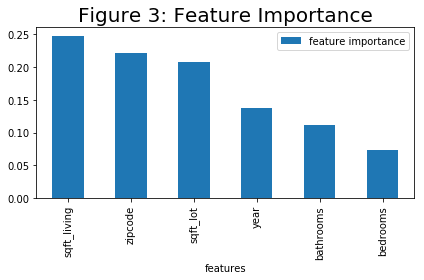

In [19]:
# plot feature importance manually
from numpy import loadtxt
from matplotlib import pyplot

fi = pd.DataFrame()
fi['features'] = df_test.columns[1:-3]
fi['feature importance'] = xgb2.feature_importances_
#fi = fi.sort(['feature importance'], ascending = [0])
#fi = pd.DataFrame(fi)
fi = fi.sort_values(['feature importance'], ascending=[0])
print(fi)

# plot
fi.plot(kind='bar', x='features')
plt.title('Figure 3: Feature Importance', size = 20)
plt.tight_layout()

In [21]:
# final model 

xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=406,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.9,
 objective= 'reg:linear',
 reg_alpha = 100, 
 nthread=4,
 scale_pos_weight=1,
 seed=100)

# data set used for training
print(df_train)
xgb2.fit(df_train[predictors], df_train['price'],eval_metric='rmse')
dtest_predictions = xgb2.predict(df_test[predictors])
print("r2 Score : %.4g" % metrics.r2_score(df_test['price'].values, dtest_predictions))

               id  bedrooms  bathrooms  sqft_living  sqft_lot  zipcode  year  \
0      3990200065  4         2.50       2050         9143      98166    1992   
1      1525069021  3         2.50       2580         214315    98053    1986   
2      9553200125  3         1.50       2440         5750      98115    1939   
3      3080000030  3         2.50       2230         4000      98144    1954   
4      3782760040  3         3.25       2780         4002      98019    2009   
5      5152960350  4         2.75       2390         9650      98003    1976   
6      3992700585  3         1.75       1880         9360      98125    1941   
7      6071700020  3         2.25       1640         8400      98006    1962   
8      3902310210  4         2.50       2100         8800      98033    1980   
9      4435000705  3         1.00       1350         8700      98188    1942   
10     925049278   4         2.00       1490         4054      98115    1926   
11     9834200165  4         1.50       